<a href="https://colab.research.google.com/github/VrindaBajaj20/ai-attack-snow3g-nea1/blob/main/experiments/nea1_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, chisquare, kstest
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split

In [4]:
print("Please upload the CSV file.")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

required_columns = ["COUNT", "Direction", "Bearer ID", "LENGTH", "KEY"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

Please upload the CSV file.


Saving snow3g_keystream (1).csv to snow3g_keystream (1).csv


In [5]:
# Validate required columns
required_columns = ["KEY", "Direction", "LENGTH", "COUNT", "Bearer ID", "Keystream"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

In [14]:
# Convert binary string to numpy array of bits
def binstr_to_bits(bin_str):
    return np.array([int(b) for b in bin_str])

df['Keystream_bits'] = df['Keystream'].apply(binstr_to_bits)
df['Key_bits'] = df['KEY'].apply(lambda k: np.array([int(b) for b in bin(int(k,16))[2:].zfill(128)]))

# Stack into ML-ready arrays
X = np.stack(df['Keystream_bits'].values).astype(np.float32)
y = np.stack(df['Key_bits'].values).astype(np.int32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Preprocessing done. Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Preprocessing done. Shapes:
X_train: (80, 128) y_train: (80, 128)
X_test: (20, 128) y_test: (20, 128)


In [16]:
import numpy as np
from scipy.stats import entropy, chisquare, kstest

# Assuming df['Keystream_bits'] is already converted to numpy arrays
Keystream_bits = np.stack(df['Keystream_bits'].values)  # shape: (num_samples, 128)

# Shannon entropy per bit position
shannon_entropy = []
for i in range(128):
    counts = np.bincount(Keystream_bits[:, i], minlength=2)
    probs = counts / counts.sum()
    shannon_entropy.append(entropy(probs, base=2))

# Chi-square test for uniform distribution
chi_square_p_values = []
for i in range(128):
    observed = np.bincount(Keystream_bits[:, i], minlength=2)
    expected = [len(Keystream_bits) / 2] * 2
    stat, p = chisquare(observed, f_exp=expected)
    chi_square_p_values.append(p)

# Kolmogorov-Smirnov Test for Randomness
ks_p_values = []
for i in range(128):
    bit_col = Keystream_bits[:, i]
    bit_series = np.cumsum(bit_col)
    normalized = (bit_series - np.mean(bit_series)) / np.std(bit_series)
    _, p = kstest(normalized, 'norm')

    ks_p_values.append(p)

print("Shannon entropy:", shannon_entropy)
print("Chi-square p-values:", chi_square_p_values)
print("KS test p-values:", ks_p_values)


Shannon entropy: [np.float64(0.9974015885677396), np.float64(0.9974015885677396), np.float64(0.9927744539878083), np.float64(0.99971144175281), np.float64(0.9709505944546688), np.float64(0.9895875212220555), np.float64(0.9953784388202258), np.float64(0.9974015885677396), np.float64(0.9974015885677396), np.float64(0.9974015885677396), np.float64(0.9953784388202258), np.float64(0.9858150371789199), np.float64(1.0), np.float64(0.9988455359952018), np.float64(0.9988455359952018), np.float64(0.9988455359952018), np.float64(0.9709505944546688), np.float64(0.9895875212220555), np.float64(0.9858150371789199), np.float64(0.9974015885677396), np.float64(0.9953784388202258), np.float64(0.9953784388202258), np.float64(0.9858150371789199), np.float64(0.9953784388202258), np.float64(0.9974015885677396), np.float64(0.9974015885677396), np.float64(0.9988455359952018), np.float64(0.99971144175281), np.float64(0.9974015885677396), np.float64(0.99971144175281), np.float64(0.9974015885677396), np.float64(

In [17]:
entropy_df = pd.DataFrame({
    "Bit Position": np.arange(128),
    "Shannon Entropy": shannon_entropy,
    "Chi-Square p-value": chi_square_p_values,
    "KS-Test p-value": ks_p_values
})

print(entropy_df.describe())

       Bit Position  Shannon Entropy  Chi-Square p-value  KS-Test p-value
count    128.000000       128.000000          128.000000       128.000000
mean      63.500000         0.991329            0.480682         0.276728
std       37.094474         0.013159            0.292644         0.180576
min        0.000000         0.914926            0.000674         0.031915
25%       31.750000         0.989588            0.230139         0.148285
50%       63.500000         0.997402            0.548506         0.223131
75%       95.250000         0.998846            0.689157         0.346528
max      127.000000         1.000000            1.000000         0.906700


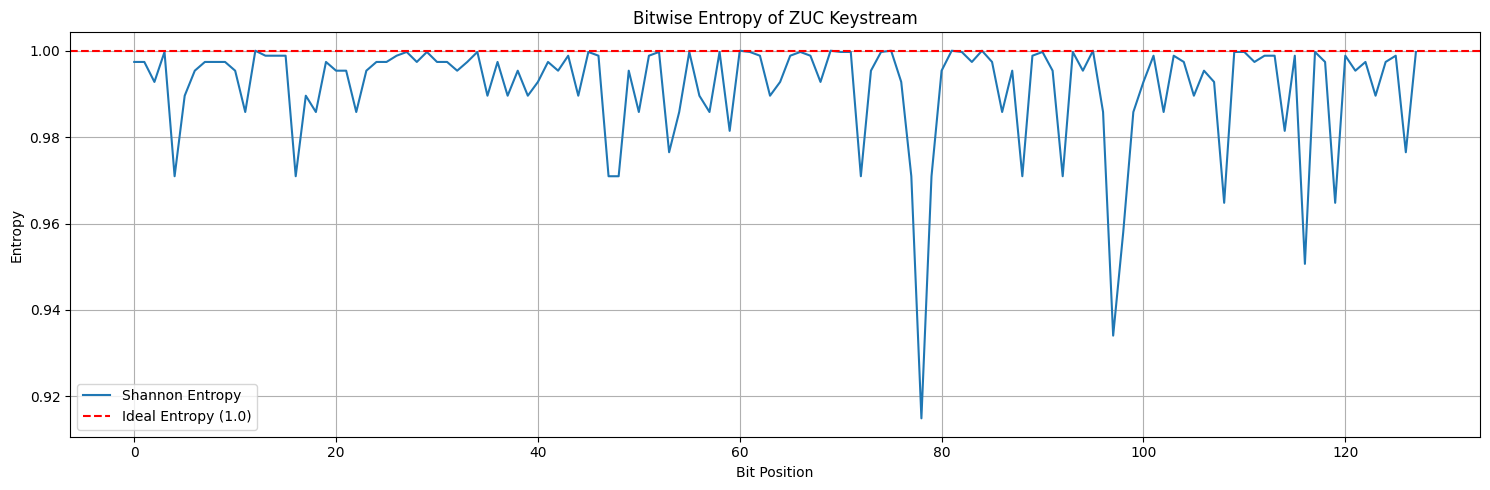

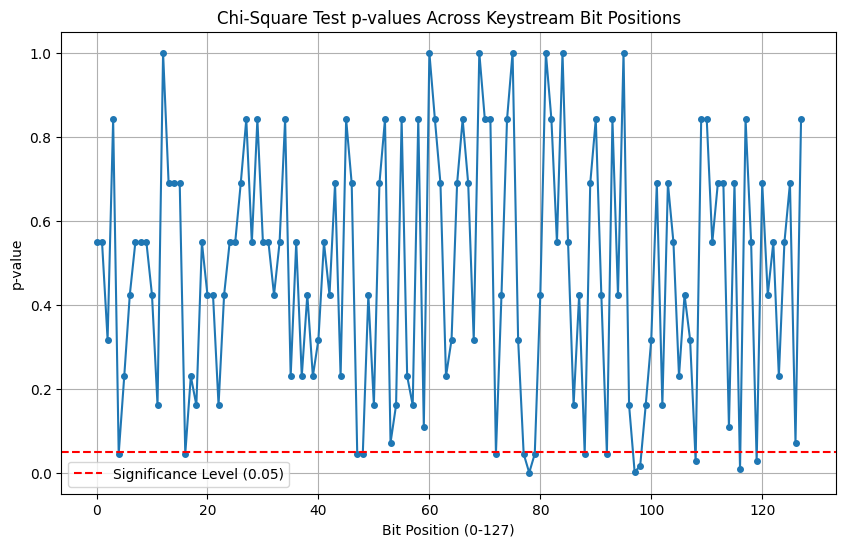

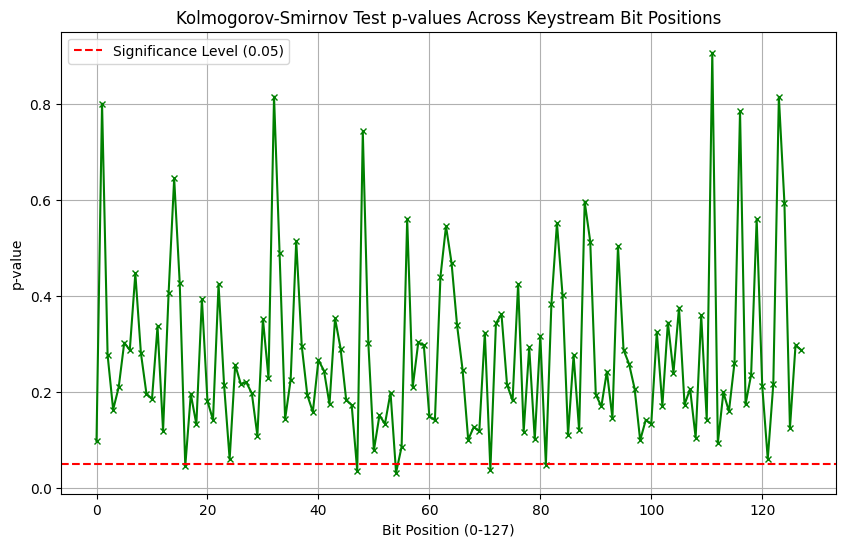

In [18]:
# shannon-entropy
plt.figure(figsize=(15, 5))
plt.plot(entropy_df['Bit Position'], entropy_df['Shannon Entropy'], label="Shannon Entropy")
plt.title("Bitwise Entropy of ZUC Keystream")
plt.xlabel("Bit Position")
plt.ylabel("Entropy")
plt.grid(True)
plt.axhline(y=1.0, color='r', linestyle='--', label='Ideal Entropy (1.0)')
plt.legend()
plt.tight_layout()
plt.show()

# chi-square test
plt.figure(figsize=(10, 6))
plt.plot(range(128), chi_square_p_values, marker='o', linestyle='-', markersize=4)
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.title('Chi-Square Test p-values Across Keystream Bit Positions')
plt.xlabel('Bit Position (0-127)')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.show()

# Kolmogorov-smirnov test
plt.figure(figsize=(10, 6))
plt.plot(range(128), ks_p_values, marker='x', linestyle='-', markersize=4, color='green')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.title('Kolmogorov-Smirnov Test p-values Across Keystream Bit Positions')
plt.xlabel('Bit Position (0-127)')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.show()